In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb

%matplotlib inline

In [3]:
company=pd.read_csv("C:/Users/samee/OneDrive/Desktop/MScoursework/data science projects/Interview Practice/TakeHomes/workplace_regression/company_hierarchy.txt", sep=",")
company.head()

,employee_id,boss_id,dept
0,46456,175361.0,sales
1,104708,29733.0,HR
2,120853,41991.0,sales
3,142630,171266.0,HR
4,72711,198240.0,sales


In [4]:
company.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   employee_id  10000 non-null  int64  
 1   boss_id      9999 non-null   float64
 2   dept         10000 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [5]:
employee=pd.read_csv("C:/Users/samee/OneDrive/Desktop/MScoursework/data science projects/Interview Practice/TakeHomes/workplace_regression/employee.txt", sep=",")
employee.head()

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience
0,138719,0,273000.0,Master,M,2
1,3192,0,301000.0,Bachelor,F,1
2,114657,0,261000.0,Master,F,2
3,29039,0,86000.0,High_School,F,4
4,118607,0,126000.0,Bachelor,F,3


In [6]:
employee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   employee_id     10000 non-null  int64  
 1   signing_bonus   10000 non-null  int64  
 2   salary          10000 non-null  float64
 3   degree_level    10000 non-null  object 
 4   sex             10000 non-null  object 
 5   yrs_experience  10000 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 468.9+ KB


In [7]:
employee.describe()

,employee_id,signing_bonus,salary,yrs_experience
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,100001.855800,0.301400,189111.800000,3.875200
std,57500.488641,0.458889,88973.796898,3.107409
min,40.000000,0.000000,60000.000000,1.000000
25%,50574.500000,0.000000,110000.000000,2.000000
50%,99244.500000,0.000000,182000.000000,3.000000
75%,149748.500000,1.000000,255000.000000,5.000000
max,199956.000000,1.000000,700000.000000,34.000000


In [32]:
# merge employee and company information
data = pd.merge(left=employee, right=company, on='employee_id')
data.head()

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience,boss_id,dept
0,138719,0,273000.0,Master,M,2,43602.0,engineering
1,3192,0,301000.0,Bachelor,F,1,87847.0,sales
2,114657,0,261000.0,Master,F,2,180854.0,sales
3,29039,0,86000.0,High_School,F,4,88370.0,HR
4,118607,0,126000.0,Bachelor,F,3,23565.0,sales


Question 1
In the company there are 6 levels. Identify, for each employee, their corresponding level.

In [10]:
data['dept'].unique()

array(['engineering', 'sales', 'HR', 'marketing', 'CEO'], dtype=object)

In [52]:
levels = ['CEO', 'E', 'VP', 'D', 'MM', 'IC']
data.loc[data['dept']=='CEO', 'level']='CEO'

for i in range(len(levels) - 1):
    boss_level = levels[i]
    empl_level = levels[i + 1]
    boss_id = data[data['level'] == boss_level]['employee_id']
    data.loc[data['boss_id'].isin(boss_id), 'level'] = empl_level

In [14]:
data[['employee_id', 'level']].sample(10)

,employee_id,level
7454,180706,IC
5456,49793,IC
2305,79552,IC
8803,180199,IC
7018,26268,IC
3003,182184,IC
7606,99085,IC
5828,128692,IC
217,79637,IC
2222,55744,IC


In [16]:
data['level'].value_counts()

IC     9000
MM      800
D       160
VP       35
E         4
CEO       1
Name: level, dtype: int64

In [53]:
boss_ids = data[data['level'] == 'IC']['boss_id']
employee_ids = data[data['level'] == 'IC']['employee_id']

In [54]:
data['counts'] = 0

for level in ['IC', 'MM', 'D', 'VP', 'E']:
    boss_ids = data[data['level'] == level]['boss_id']
    employee_ids = data[data['level'] == level]['employee_id']
    for b_id, e_id in zip(boss_ids, employee_ids):
        e_counts = int(1 + data.loc[data['employee_id'] == e_id, 'counts'])
        b_counts = int(data.loc[data['employee_id'] == b_id, 'counts'])
        data.loc[data['employee_id'] == b_id, 'counts'] = e_counts + b_counts

In [22]:
data[['employee_id', 'level', 'counts']].sample(10)

,employee_id,level,counts
2748,131820,IC,0
2348,168545,D,26
358,167986,IC,0
8901,23781,IC,0
6570,161539,IC,0
6552,58544,IC,0
9519,82636,IC,0
1746,174122,MM,11
1734,60713,IC,0
463,142104,MM,9


Build a model to predict the salary of each employee

In [23]:
data.head()

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience,boss_id,dept,level,counts
0,138719,0,273000.0,Master,M,2,43602.0,engineering,IC,0
1,3192,0,301000.0,Bachelor,F,1,87847.0,sales,IC,0
2,114657,0,261000.0,Master,F,2,180854.0,sales,IC,0
3,29039,0,86000.0,High_School,F,4,88370.0,HR,IC,0
4,118607,0,126000.0,Bachelor,F,3,23565.0,sales,IC,0


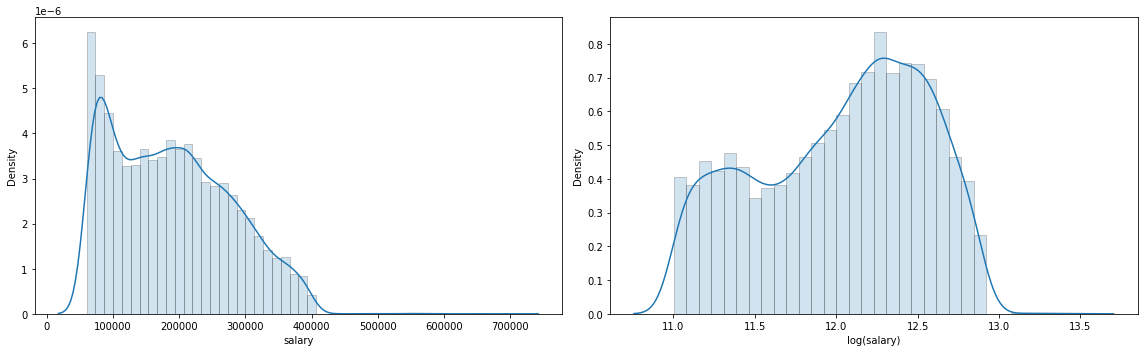

In [24]:
# Distribution of salary
warnings.filterwarnings('ignore')
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
sns.distplot(data['salary'], ax=ax[0], hist_kws=hist_kws)
sns.distplot(np.log(data['salary']), ax=ax[1], hist_kws=hist_kws)
ax[1].set_xlabel('log(salary)')
plt.tight_layout()
plt.show()

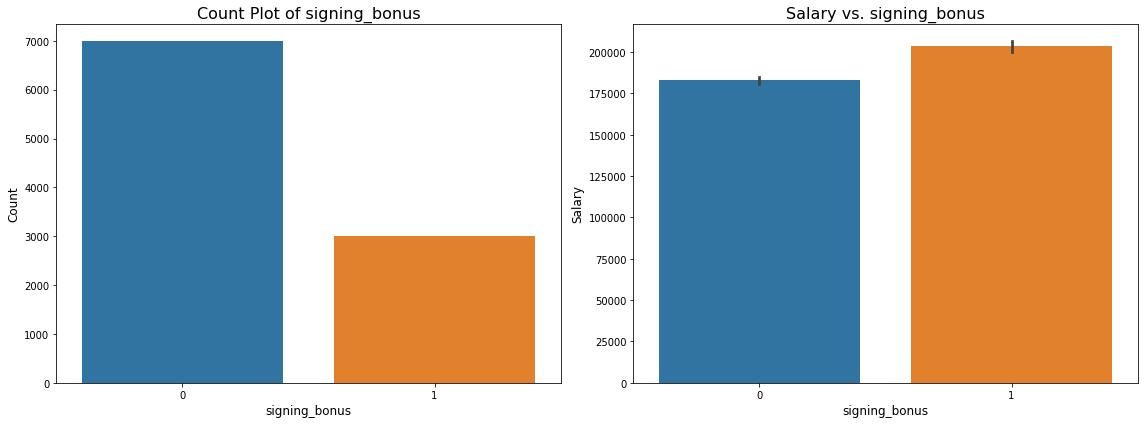

In [25]:
# visualization of 'signing_bonus'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='signing_bonus', data=data, ax=ax[0])
ax[0].set_xlabel('signing_bonus', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of signing_bonus', fontsize=16)

sns.barplot(x='signing_bonus', y='salary', data=data, ax=ax[1])
ax[1].set_xlabel('signing_bonus', fontsize=12)
ax[1].set_ylabel('Salary', fontsize=12)
ax[1].set_title('Salary vs. signing_bonus', fontsize=16)
plt.tight_layout()
plt.show()

Build Machine Learning Models with LightGBM

In [55]:
# Drop CEO department
data = data[data['dept'] != 'CEO']

# drop useless features
data = data.drop(labels=['employee_id', 'boss_id', 'level', 'counts'], axis=1)

data.head()

,signing_bonus,salary,degree_level,sex,yrs_experience,dept
0,0,273000.0,Master,M,2,engineering
1,0,301000.0,Bachelor,F,1,sales
2,0,261000.0,Master,F,2,sales
3,0,86000.0,High_School,F,4,HR
4,0,126000.0,Bachelor,F,3,sales


In [56]:
#encoding categorical data
data['sex'] = (data['sex'] == 'M').astype(int)

degree_encoder = LabelEncoder()
data['degree_level'] = degree_encoder.fit_transform(data['degree_level'])

dept_encoder = LabelEncoder()
data['dept'] = dept_encoder.fit_transform(data['dept'])

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9999 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   signing_bonus   9999 non-null   int64  
 1   salary          9999 non-null   float64
 2   degree_level    9999 non-null   int32  
 3   sex             9999 non-null   int32  
 4   yrs_experience  9999 non-null   int64  
 5   dept            9999 non-null   int32  
dtypes: float64(1), int32(3), int64(2)
memory usage: 429.6 KB


In [58]:
# define categorical features
categorical_feature = ['signing_bonus', 'degree_level', 'sex', 'dept']
data[categorical_feature] = data[categorical_feature].astype('category')

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9999 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   signing_bonus   9999 non-null   category
 1   salary          9999 non-null   float64 
 2   degree_level    9999 non-null   category
 3   sex             9999 non-null   category
 4   yrs_experience  9999 non-null   int64   
 5   dept            9999 non-null   category
dtypes: category(4), float64(1), int64(1)
memory usage: 274.0 KB


In [59]:
# split into training and test data set
X = data.drop('salary', axis=1)
y = data['salary']

X_train, X_test, y_train, y_test \
    = train_test_split(X, y, test_size=0.25, random_state=42)

# transform into log scale
y_train = np.log(y_train)
y_test = np.log(y_test)

In [60]:
# create LightGBM dataset
d_train = lgb.Dataset(data=X_train, label=y_train, free_raw_data=False, 
                      categorical_feature=categorical_feature)

In [61]:
# Cross validation
params = {'learning_rate': 0.01, 
          'boosting_type': 'gbdt', 
          'objective': 'regression', 
          'metric': 'rmse', 
          'sub_feature':0.5, 
          'num_leaves': 31, 
          'min_data': 50, 
          'max_depth': 30}

history = lgb.cv(params, train_set=d_train, num_boost_round=1000, nfold=5, 
                 early_stopping_rounds=20, seed=42, stratified=False)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 45
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 5
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [63]:
best_round = len(history['rmse-mean'])
print('Best rounds:\t', best_round)

Best rounds:	 474


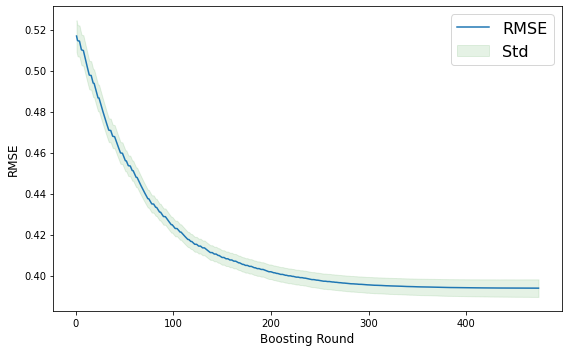

In [64]:
# visualization
rmse = np.array(history['rmse-mean'])
std = np.array(history['rmse-stdv'])
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(range(1, best_round + 1), rmse, label='RMSE')
ax.fill_between(range(1, best_round + 1), rmse + std, rmse - std, 
                alpha=0.1, color='g', label='Std')
ax.set_xlabel('Boosting Round', fontsize=12)
ax.set_ylabel('RMSE', fontsize=12)
ax.legend(fontsize=16)
plt.tight_layout()
plt.show()

In [65]:
# re-train the model and make predictions
clf = lgb.train(params, train_set=d_train, num_boost_round=best_round)
pred = clf.predict(X_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 45
[LightGBM] [Info] Number of data points in the train set: 7499, number of used features: 5
[LightGBM] [Info] Start training from score 12.020859
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [66]:
print('Test RMSE:\t', np.sqrt(mean_squared_error(y_test, pred)))
print('Test R2:\t', r2_score(y_test, pred))

Test RMSE:	 0.39080803975717354
Test R2:	 0.4020007295623995


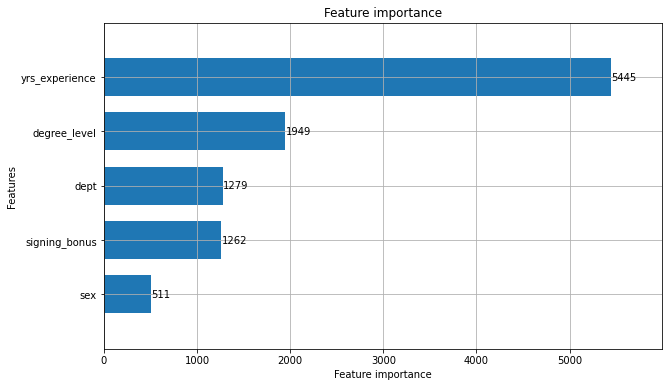

In [67]:
# feature importance
features = clf.feature_name()
importance = clf.feature_importance()

fig, ax = plt.subplots(figsize=(10, 6))
lgb.plot_importance(clf, ax=ax, height=0.7)
plt.show()

from above plot, we can see that, more subordinates (i.e., higher level), more positive bias, means more likely to be overpaid.

Is it fair? Any bias?
I think, in large scope, the company treat its employee fairly. the difference among different sex and departments seems normal and fair enough.

the only bias I can see is that, the management level is likely to be overpaid. Higher the level, more likely to be overpaid.

Suggestions to HR header
I may suggest him/her considering lower down the salaries in high management level , which may be more fair to the workforce.